In [116]:
import pandas as pd
import numpy as np

In [117]:
predicted_prices = pd.read_csv("predicted_stock_prices.csv")
predicted_prices.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
predicted_prices['Date'] = pd.to_datetime(predicted_prices['Date'], format='%Y-%m-%d')
predicted_prices.set_index('Date', inplace=True)

In [118]:
predicted_prices = predicted_prices.apply(pd.to_numeric)
daily_returns = predicted_prices.pct_change()
daily_returns = daily_returns.dropna()

In [119]:
def annualize_rets(r, periods_per_year):
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    return r.std()*(periods_per_year**0.5)

In [121]:
annualised_daily_returns = annualize_rets(daily_returns, 365)
volatility_daily_returns = annualize_vol(daily_returns, 365)

In [122]:
import numpy as np         
import pandas as pd         
import matplotlib.pyplot as plt  
from scipy.optimize import minimize  

def portfolio_return(weights, returns):
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

def msr(riskfree_rate, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n 
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def gmv(cov):
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def optimal_weights(n_points, er, cov):
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend)
    if show_cml:
        ax.set_xlim(left = 0)
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
        
        return ax

In [123]:
cov_matrix = daily_returns.cov()
l = ['ASIANPAINT.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'HCLTECH.NS',
       'INFY.NS', 'TCS.NS', 'TECHM.NS']
cov_matrix_final = cov_matrix.loc[l,l]

In [129]:
gmv_weights = gmv(cov_matrix_final)
msr_weights = msr(0.0697, annualised_daily_returns, cov_matrix_final)

In [131]:
print(gmv_weights)
print(msr_weights)

[0.1966477  0.13984027 0.21313399 0.06534991 0.108151   0.18365712
 0.09322002]
[4.24689410e-13 0.00000000e+00 2.84356192e-01 6.29304990e-12
 1.47187965e-01 4.75904053e-01 9.25517896e-02]


<Axes: xlabel='Volatility'>

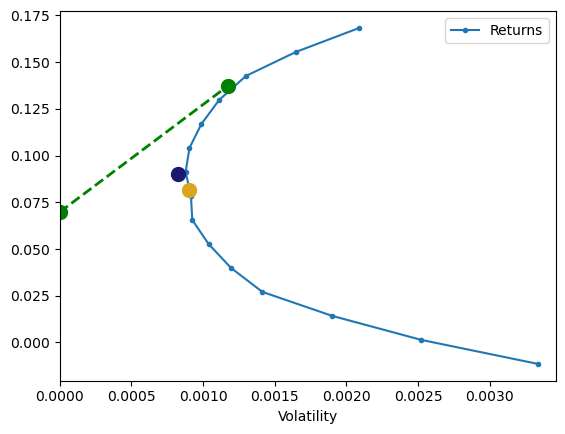

In [136]:
plot_ef(15, annualised_daily_returns, cov_matrix_final, style='.-', legend=True, show_cml=True, riskfree_rate=0.06971, show_ew=True, show_gmv=True)